$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge simulate$ $\hspace{0.1cm}$ $\Huge radio$ $\hspace{0.1cm}$ $\Huge point$ $\hspace{0.1cm}$ $\Huge sources$ $\Huge :$ 

# Modules : 

In [12]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt 
from matplotlib import rc
rc('text', usetex=True)
from astropy.io import fits
import numpy as np
from astropy import constants as cst
from astropy.cosmology import FlatLambdaCDM
import pysm as pysm
import ccatp_sky_model as sky
from tqdm import tqdm 

In [13]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value

In [14]:
data_path = "/vol/arc3/data1/sz/CCATp_sky_model/templates/"

# Function : 

In [17]:
def simulate_radio_ps(freq, nside_out = 4096, lmax = None, beam_FWHM = None, template = 'WebSky', unit = 'cmb'):

    '''Computes an all-sky radio point source map at a given frequency and nside based on 
    the simulations provided by Sehgal et al. (2010), which have been recalibrated by the
    SO collaboration. The original simulations by Sehgal et al. are modelled by a curved 
    power law and can be extrapolated to frequencies beyoned 350 GHz, while the sources in 
    the SO simulations show more complex spectra due to ringing artifacts caused by the 
    processing of the maps with alter_alm(). Due to these complex SEDs, bilinear interpolation
    is applied for input frequencies between 27 and 353 GHz. For higher frequencies, a null
    map is returned.
    Parameters
    ----------
    freq: float or float array
        Frequency of the output map in Hz.
    nside_out: float, optional
        Healpix nside parameter of the output map. Must be a valid value for nside.
        Default: 4096
    lmax: float, optional
        Maximum value of the multipolemoment at which the atmospheric power spectrum
        wil be computed. Default: 3*nside_out-1            
    beam_FWHM: bool, optional
        If set, the output will be convolved with a gaussian. The FWHM of the Gaussian
        in units of arcmin is given by the provided value. Default: None
    template: bool, optional
        Determines the all-sky foregrounds templates to be used to build the sky model.
        If 'Sehgal' is chosen, simulations by Sehgal et al. (2010) are used.
        If 'SO' is chosen, the Simons Observatory sky model provided by Colin Hill and 
        based on the simulations by Sehgal et al. (2010) is used. If 'WebSky' is chosen,
        the used templates will be based on the WebSky Extragalactic CMB Mocks provided 
        by CITA. If 'SO_reproduced' is chosen, the SO sky model is reproduced directly 
        from the Sehgal et al. (2010) data. Default: 'WebSky'
    unit: bool, optional
        Determines the units of the output map. The available units are 'mjy' --> MJy/sr
        (specific intensity), 'cmb' --> K_CMB (thermodynamic temperature), and 
        'rj' --> K_RJ (brightness temperature). Default: 'cmb'.
    Returns
    -------
    radio_ps: float array
        Healpix all-sky map of the radio point source emission at the specified frequency.
    '''

    if lmax is None:
        lmax = int(3*nside_out-1)
    
    if template != 'SO' and template != 'WebSky' and template != 'Sehgal' and template != 'SO_reproduced':
        print('Waring: Unknown template requested! Output will be based on SO sky model')
        template = 'WebSky'	
	
    if template == 'SO':

        npix = hp.pixelfunc.nside2npix(4096)
        radio_ps = np.zeros(npix)
        
        #Define frequencies
        nu = np.array([27,30,39,44,70,93,100,143,145,217,225,280,353])*1e9
        nu_names = ['027','030','039','044','070','093','100','143','145','217','225','280','353']

        #Interpolate data points
        if freq > np.max(nu):
            print('Warning: Input frequency lies beyoned the 353 GHz. Since higher frequencies are not constraint by simulations, the data will be 0.')
        else:
		
            #Read data files
            data = np.zeros((len(nu), npix), dtype = np.float32)

            for i in np.arange(len(nu)):
                file_name = data_path + 'radio_ps/' + nu_names[i] + '_rad_pts_healpix_nopell_Nside4096_DeltaT_uK_fluxcut148_7mJy_lininterp.fits'
                data[i,:] = hp.fitsfunc.read_map(file_name, dtype = np.float32) * sky.convert_units(nu[i], 1e-6, cmb2mjy=True)		
		
            for i in tqdm(np.arange(npix)):
                radio_ps[i] = np.interp(freq, nu, data[:,i])
		
            del data		

    elif (template == 'Sehgal') or (template == 'SO_reproduced'):

        if template == 'SO_reproduced':

            file_name = data_path + 'radio_ps/148_rad_pts_healpix.fits'
            map_148 = hp.fitsfunc.read_map(file_name, dtype = np.float32)/1e6
            
            solid_angle = 4*np.pi / hp.nside2npix(8192)        
            threshold = 7e-3 / solid_angle / 1e6 #defines 7 mJy source cut at 148 GHz in units of MJy/sr for nside = 8192
            flagged = map_148 > threshold
            del map_148

        #Read data files
        file_name = data_path + 'radio_ps/030_rad_pts_healpix.fits'
        map_30 = hp.fitsfunc.read_map(file_name, dtype = np.float32)/1e6

        file_name = data_path + 'radio_ps/Sehgal_radio_ps_spectral_index_8192.fits'
        spectral_index = hp.fitsfunc.read_map(file_name, dtype = np.float32)

        file_name = data_path + 'radio_ps/Sehgal_radio_ps_f_crit_8192.fits'
        crit_freq = hp.fitsfunc.read_map(file_name, dtype = np.float32)

        #Extrapolate fluxes
        radio_ps = map_30*(freq/30e9)**spectral_index * np.exp(-freq/crit_freq)

        if template == 'SO_reproduced':
            radio_ps[flagged] = 0

        del map_30, spectral_index, crit_freq	
				
    elif template == 'WebSky':
        print('Warning: No radio PS template provided by the WebSky simulations')
        npix = hp.pixelfunc.nside2npix(4096)
        radio_ps = np.zeros(npix)

    #Re-bin map if necessary
    if hp.get_nside(radio_ps) != nside_out:
        radio_ps = hp.pixelfunc.ud_grade(radio_ps, nside_out = nside_out)

    #Smooth map if necessary
    if beam_FWHM is not None:
        print('begin smoothing')
        radio_ps = hp.sphtfunc.smoothing(radio_ps, iter = 0, lmax = lmax, fwhm = beam_FWHM/60*np.pi/180)

    #Convert units if necessary
    if unit == 'mjy':
        None
    elif unit == 'cmb':
        radio_ps = sky.convert_units(freq, radio_ps, mjy2cmb=True)
    elif unit == 'rj':
        radio_ps = sky.convert_units(freq, radio_ps, mjy2rj=True)
    else:
        radio_ps = sky.convert_units(freq, radio_ps, mjy2cmb=True)
        print('Waring: Unknown unit! Output will be in K_CMB')

    #Return output
    return(np.float32(radio_ps))

# Launch : 

In [18]:
RPS = simulate_radio_ps(freq=150e9, nside_out = 1024, lmax = None, beam_FWHM = None, template = 'SO',
                        unit = 'cmb')

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


100%|██████████| 201326592/201326592 [20:36<00:00, 162813.70it/s]


masked_array(
  data=[[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],
  mask=False,
  fill_value=-1.6375e+30)

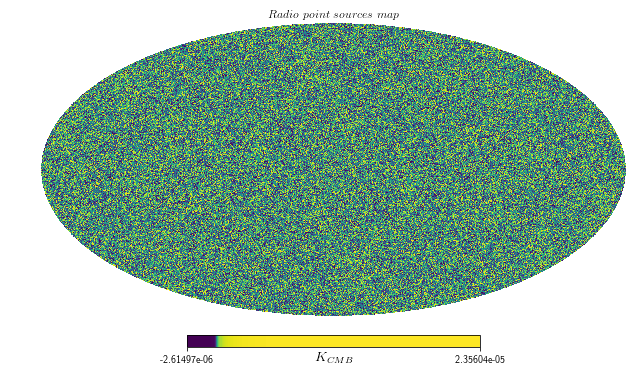

In [21]:
hp.mollview(map=RPS, coord=None, nest=False, title='$Radio$ $point$ $sources$ $map$',
            unit='$K_{CMB}$', norm='hist', xsize=2000,return_projected_map=True)